In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns

#for differnt color 
color = sns.color_palette()
sns.set_style('darkgrid')

'''statistical packages'''
from scipy import stats
from scipy.stats import norm, skew


In [2]:
#sklearn linear models -->ElasticNEt, Lasso, BayesianRidge, lassolarsIC
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC

#sklearn ensemble models
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, ExtraTreesRegressor

# estimator
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

from sklearn.kernel_ridge import KernelRidge
'''
Kernel ridge regression (KRR) combines ridge regression (linear least squares with l2-norm regularization) 
with the kernel trick. It thus learns a linear function in the space induced by the respective kernel and the data. 
For non-linear kernels, 
this corresponds to a non-linear function in the original space
'''
from sklearn.metrics import mean_squared_error

import xgboost as xgb
import lightgbm as lgb


# PIPELINE AND SCALING PREPROCESSING
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel

In [38]:
# MODEL SELECTION PACKAGES USED FOR SAMPLING DATASET AND OPTIMISING PARAMETERS
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, train_test_split

In [41]:
from sklearn.model_selection import ShuffleSplit

In [3]:
#importing dataset
train = pd.read_csv('price_data_tr.csv')
val = pd.read_csv('price_data_val.csv')
test = pd.read_csv('price_data_ts.csv')

In [4]:
# KEEPING A COPY OF TRAIN AND TEST DB FOR FURTHER USAGE
rawTrain = train.copy()
rawTest = test.copy()
rawVal = val.copy()

In [5]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,1310440590,20150413T000000,440000.0,3,2.50,2290,6302,2.0,0,0,...,9,2290,0,1997,0,98058,47.4350,-122.107,2700,7500
1,1437580480,20140918T000000,994000.0,5,3.25,4260,7861,2.0,0,0,...,10,4260,0,2005,0,98074,47.6110,-121.992,4020,7528
2,7617500075,20140721T000000,427000.0,3,1.75,2000,7111,1.0,0,0,...,7,1360,640,1956,0,98177,47.7676,-122.373,1830,9000
3,8122100130,20140618T000000,415000.0,3,1.75,1270,4800,1.0,0,0,...,7,1270,0,1952,2014,98126,47.5362,-122.376,1220,4800
4,4476400275,20150114T000000,335000.0,3,1.75,2100,8298,1.0,0,0,...,7,1230,870,1952,0,98166,47.4601,-122.360,1700,10830


In [6]:
# SAVING ID COLUMNS
train_ID = train['id']
test_ID = test['id']
val_ID = val['id']

test_date = test['date']

#dropping id and date
train = train.drop(['id', 'date'], axis=1)
val = val.drop(['id', 'date'], axis=1)
test = test.drop(['id','date'], axis=1)


Number of Neumeric Columns =  19


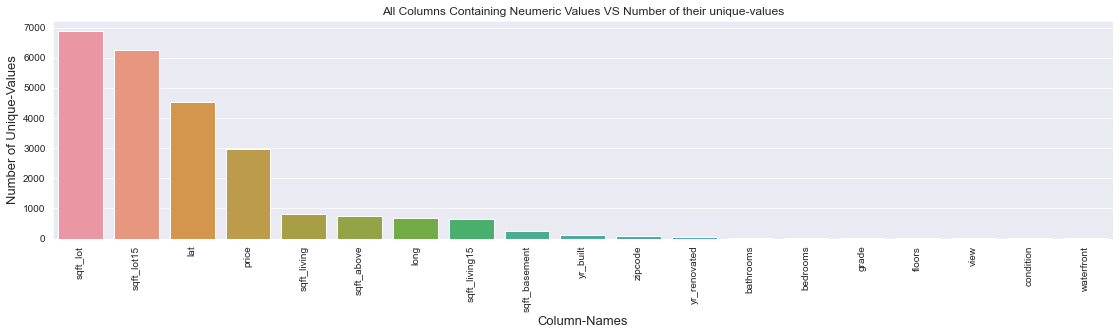

In [7]:
#finding unique values

# SEPARATING NUMERIC COLUMNS
numeric_columns = train.select_dtypes(exclude=['object']).columns.values.tolist()
#print(numeric_columns)
print('Number of Neumeric Columns = ',len(numeric_columns))
unique_values=[]
for item in numeric_columns: 
    unique_values.append(train[item].nunique())
numeric_column_list = list(zip(numeric_columns, unique_values))
#(numeric_column_list)
numeric_column_list = sorted(numeric_column_list,key=lambda l:l[1], reverse=True)
numeric_column_list=pd.DataFrame(numeric_column_list, columns=['Column-Names', 'Unique-Values'])
                                                  
                                                  # PLOTTING NUMBER OF UNIQUE-VALUES FOR EACH NUMERIC COLUMNS
plt.subplots(figsize=(19, 4))
sns.barplot(x=numeric_column_list['Column-Names'], y=numeric_column_list['Unique-Values'])
plt.xticks(rotation=90)
plt.ylabel('Number of Unique-Values', fontsize=13)
plt.xlabel('Column-Names', fontsize=13)
plt.title('All Columns Containing Neumeric Values VS Number of their unique-values')
plt.show()

Checking for correlation

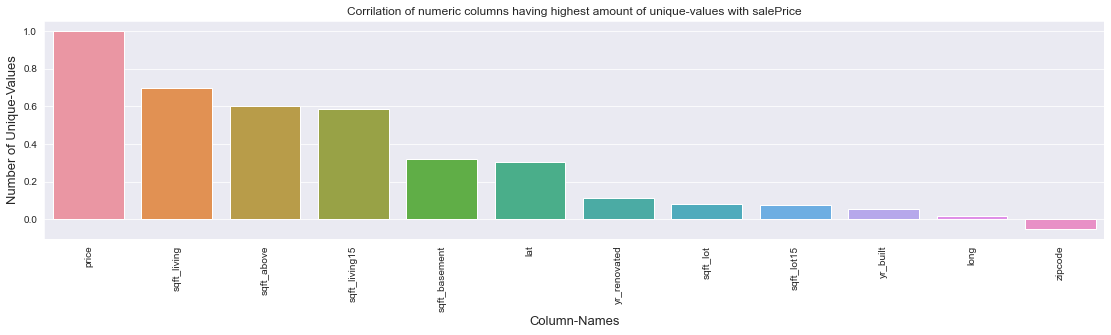

In [8]:
# CHECKING CORRELATION OF THE SELECTED COLUMNS WITH SALEPRICE
highly_unique_columns = numeric_column_list.drop(numeric_column_list[numeric_column_list['Unique-Values'] < 65].index)
#droping columns with unique values less than 65

cols = highly_unique_columns['Column-Names']
corrs=[]
for item in cols:
    corrs.append((train[item].corr(train['price'])))    # .corr is for finding correlation coefficient
    
    '''
    Pandas dataframe.corr() is used to find the pairwise correlation of all columns in the dataframe. 
    Any na values are automatically excluded. For any non-numeric data type columns in the dataframe it is ignored.
    '''
    
# MAKING A DATAFRAME TO STORE THE CORRELATIONS     
ist = pd.DataFrame(
    {'cols': cols,
     'corrs': corrs
    })
ist = ist.sort_values(by='corrs', ascending=False)

# VISUALIZING CORRELATIONS GRAPHICALLY
plt.subplots(figsize=(19, 4))
sns.barplot(x=ist['cols'], y=ist['corrs'])
plt.xticks(rotation=90)
plt.ylabel('Number of Unique-Values', fontsize=13)
plt.xlabel('Column-Names', fontsize=13)
plt.title('Corrilation of numeric columns having highest amount of unique-values with salePrice')
plt.show()

checking ofr outliers

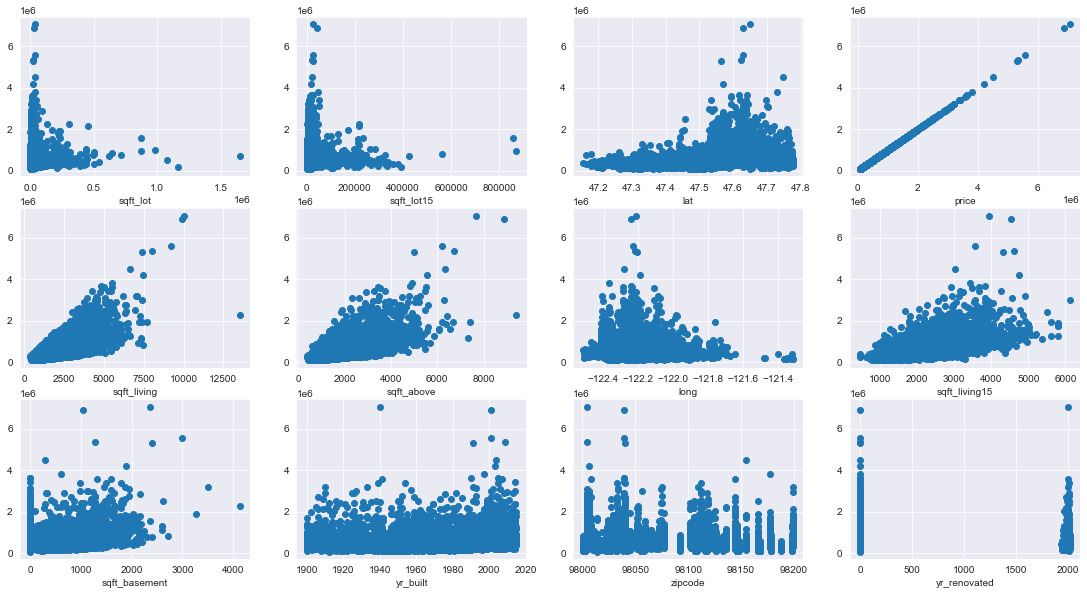

In [9]:
# a function to show relation with sales price
def relation_wid_price(c, column):
    plt.subplot(5, 4, c)
    plt.scatter(x=train[column], y=train['price'])
    plt.xlabel(column)
c=1
plt.subplots(figsize=(19, 17))
for item in cols:
    relation_wid_price(c, item)
    c = c+1
plt.show()

In [11]:
# function for removing outliers
# creating a function to remove outliers
def outlier_check_plot(column):
    plt.subplots(figsize=(19, 5))
    plt.subplot(1,3,1)
    plt.scatter(x=train[column].sort_values(ascending=False)[:12], y=train_ID[:12], color='red', label='train')
    plt.scatter(x=test[column].sort_values(ascending=False)[:12], y=test_ID[:12], label='test')
    plt.scatter(x=val[column].sort_values(ascending=False)[:12], y=val_ID[:12], label='val')
    plt.ylabel('Serial Number', fontsize=12)
    plt.xlabel(column, fontsize=12)
    plt.title('Fig 1: 12 highest-values of category {} \n in both train and test dataset'.format(column))
    plt.legend(loc='center',fontsize=13)
    
    # disribution plot od the column
    plt.subplot(1,3,2)
    sns.distplot(train[column], color='red', rug=True, hist=False, label='Train')
    sns.distplot(val[column], color='blue', rug=True, hist=False, label='val')
    sns.distplot(test[column], color='green', rug=True, hist=False, label='test')
    plt.ylabel('Distrubutuin', fontsize=13)
    plt.xlabel(column, fontsize=13)
    plt.title('fig2 :Distribution-plot of category {} \n for both train and test dataset'.format(column))
    plt.legend(fontsize=13)
    
    # SCATTER-PLOT OF THE COLUMN WITH RESPECT TO SALEPRICE 
    plt.subplot(1, 3, 3)
    plt.scatter(x = train[column], y = train['price'])
    plt.ylabel('price', fontsize=13)
    plt.xlabel(column, fontsize=13)
    plt.title('Fig 3: Scatter-plot of train-category {} \n with respect to Price'.format(column))
    plt.show()

Before outlier-removal of sqdt_lot: 


c:\users\ripon\anaconda3\envs\mldl\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\users\ripon\anaconda3\envs\mldl\lib\site-packages\seaborn\distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
c:\users\ripon\anaconda3\envs\mldl\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\users

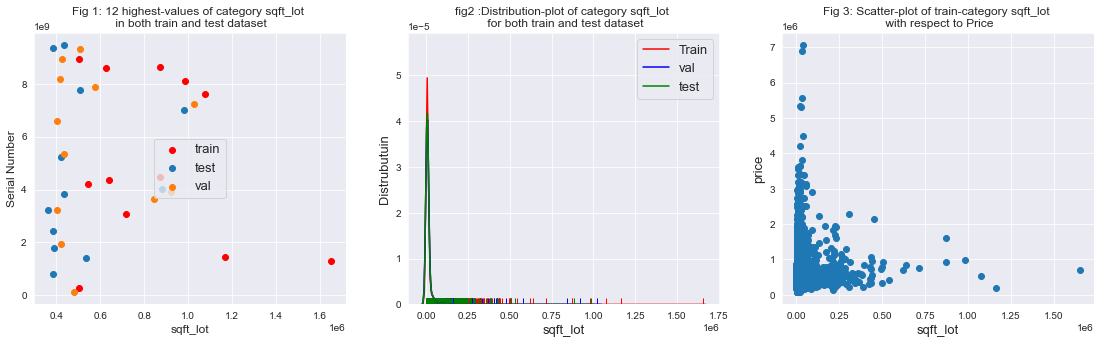

In [13]:
print('Before outlier-removal of sqdt_lot: ')
outlier_check_plot('sqft_lot')

In [21]:
# A FUNCTION TO CHECK ACTUAL AND NORMALIZED DISTRIBUTION-PLOT OF SALEPRICE
def check_distribution(column):
    
    #DISTRIBUTION-PLOT
    plt.subplots(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    sns.distplot(train[column] , fit=norm)
    (mu, sigma) = norm.fit(train[column])
    plt.legend(['mu= {:.2f} & sigma= {:.2f} in normal-dist'.format(mu, sigma)], loc='best', fontsize=13)
    plt.ylabel('Frequency')
    plt.title('distribution')
    
    # QUANTILE-QUANTILE PLOT
    plt.subplot(1, 2, 2)                                                                                
    res = stats.probplot(train[column], plot=plt)
    plt.show()

Distribution of Price before normalization:


c:\users\ripon\anaconda3\envs\mldl\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


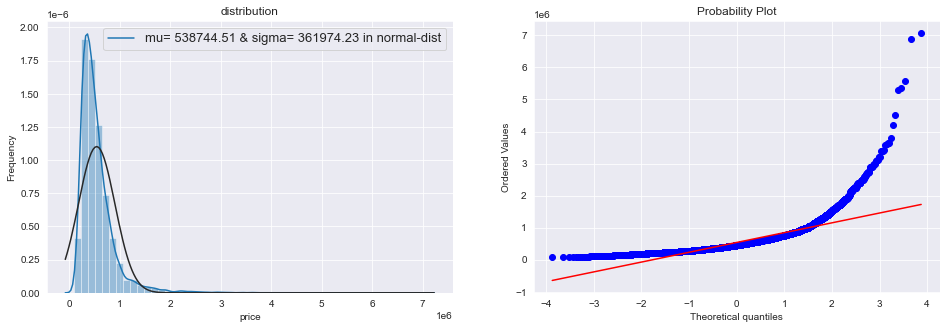

In [22]:
print('Distribution of Price before normalization:')
check_distribution('price')

Distribution of SalePrice after normalization:


c:\users\ripon\anaconda3\envs\mldl\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


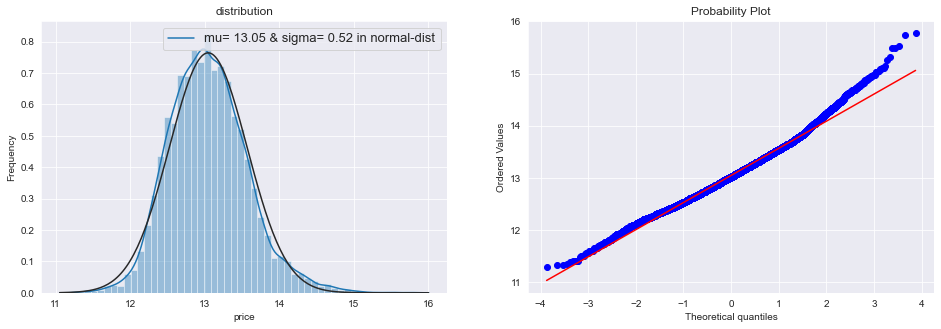

In [23]:
train["price"] = np.log1p(train["price"])
val['price'] = np.log1p(val["price"])
print('Distribution of SalePrice after normalization:')
check_distribution('price')

In [25]:
train.shape, val.shape, test.shape
#train.price.values

((12968, 19), (4323, 19), (4322, 19))

In [26]:
# SAVING TRAINING AND TEST DATA LENGTH
zero = 0
ntrain = train.shape[zero]  # nunmber of training sample/data
ntest = test.shape[zero]    # nunmber of training sample/data

# STORING TRAIN-DATA LABELS SEPARATELY
y_train = train.price.values    # swperating all the price value as y_train

# STORING TRAIN-DATA LABELS SEPARATELY
y_val = val.price.values    # swperating all the price value as y_train

# CONCATENATING TRAIN AND TEST DATAFRAME
all_data = pd.concat((train, val)).reset_index(drop=True)  #12968 + 4323 = 17291 (adding all train and validation data)

# REMOVING TRAIN-DATA LABELS
all_data.drop(['price'], axis=1, inplace=True)  # removing price data from all data

# CHECKING SIZE OF CONCATENATED DATAFRAME
print("all_data size is : {}".format(all_data.shape))

all_data size is : (17291, 18)


In [27]:
y_train.shape

(12968,)

In [28]:
# no missing data
missing_value_counts = all_data.isnull().sum()
missing_value_counts

bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

#feature engineering

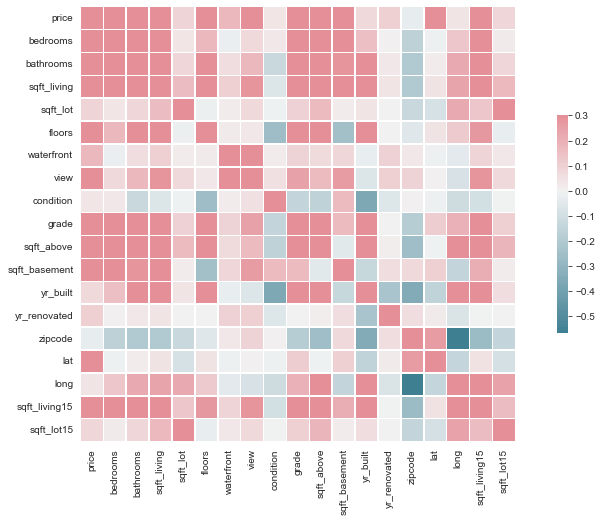

In [29]:
# plottng polynomaial features from most correlated to price

corrmat = train.corr()
plt.subplots(figsize=(15,8))
# generating colormap
cmap = sns.diverging_palette(219, 9, as_cmap=True)

# drawing the heatmap with mask and correect aspect
sns.heatmap(corrmat, cmap=cmap, vmax=0.3, center=0, 
           square=True, linewidths=0.5, cbar_kws={'shrink': .5}) #annot=True/False
plt.show()

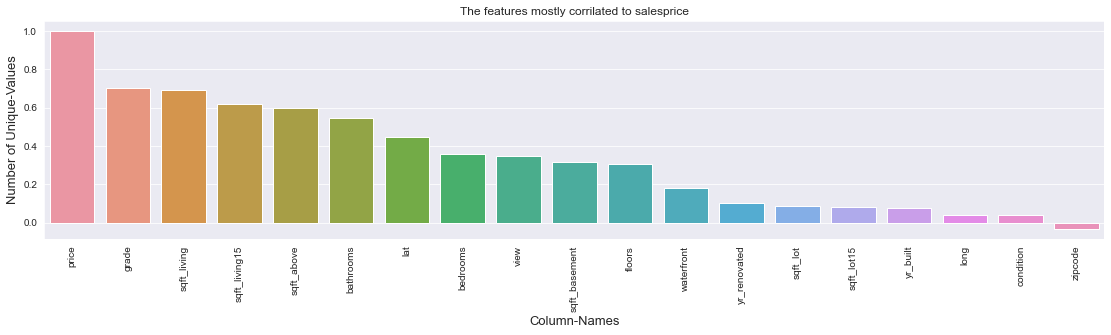

In [30]:
# THE FEATURES MOSTLY CORRELATED TO SALESPRICE
cols = train.dtypes[train.dtypes != 'object'].index
corrs=[]
for item in cols:
    corrs.append((train[item].corr(train['price'])))
    
ist = pd.DataFrame(
    {'cols': cols,
     'corrs': corrs
    })
ist = ist.sort_values(by='corrs', ascending=False)
#ist.head()
plt.subplots(figsize=(19, 4))
sns.barplot(x=ist['cols'], y=ist['corrs'])
plt.xticks(rotation=90)
plt.ylabel('Number of Unique-Values', fontsize=13)
plt.xlabel('Column-Names', fontsize=13)
plt.title('The features mostly corrilated to salesprice')
plt.show()

In [31]:
test.drop(['price'], axis=1, inplace=True)

In [32]:
all_data.columns.values

array(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat',
       'long', 'sqft_living15', 'sqft_lot15'], dtype=object)

In [33]:
# recreating train and val/test data

train = all_data[:ntrain]
valid = all_data[ntrain:]

#making copy
trainCopyMod = train.copy()
validCopyMod = valid.copy()
testCopyMod = test

train.shape, valid.shape, y_train.shape, test.shape

((12968, 18), (4323, 18), (12968,), (4322, 18))

In [78]:
model = xgb.XGBRegressor()
model.fit(xgb_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [36]:
# regression model implementataion

xgb_train = train.copy()
xgb_valid = valid.copy()
xgb_test = test.copy()

model = xgb.XGBRegressor()
model.fit(xgb_train, y_train)
#model2 = xgb.XGBRegressor()
#model2.fit(xgb_test, y=None)

# SELECTING THE MOST IMPORTANT FEATURES
xgb_feat_red = SelectFromModel(model, prefit = True)
#xgb_feat_red2 = SelectFromModel(model2, prefit = True)

# REDUCING ESTIMATION VALIDATION AND TEST DATASETS
xgb_train = xgb_feat_red.transform(xgb_train)
xgb_valid = xgb_feat_red.transform(xgb_valid)
xgb_test = xgb_feat_red.transform(xgb_test)


print("Results of 'feature_importances_':")
print('X_train: ', xgb_train.shape, '\nX_val: ', xgb_valid.shape, '\nX_test: ', xgb_test.shape)

Results of 'feature_importances_':
X_train:  (12968, 5) 
X_val:  (4323, 5) 
X_test:  (4322, 5)


c:\users\ripon\anaconda3\envs\mldl\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\users\ripon\anaconda3\envs\mldl\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\users\ripon\anaconda3\envs\mldl\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [39]:
# spliting train datset for trainin

X_train, X_test, Y_train, Y_test = model_selection.train_test_split(xgb_train, y_train, test_size=.3, random_state=42)
dataset=['X_train', 'X_test','Y_train', 'Y_test']
shape=[X_train.shape, X_test.shape, Y_train.shape, Y_test.shape]
datasets = pd.DataFrame(
    {'DataSet': dataset,
     'shape': shape
    })
datasets

,DataSet,shape
0,X_train,"(9077, 5)"
1,X_test,"(3891, 5)"
2,Y_train,"(9077,)"
3,Y_test,"(3891,)"


In [42]:
# training

# ALGORITHM SELECTION AND INITIALIZATION
models = [KernelRidge(), ElasticNet(), Lasso(), GradientBoostingRegressor(), 
          BayesianRidge(), LassoLarsIC(), RandomForestRegressor(), xgb.XGBRegressor()]

# RANDOMISING THE CROSS VALIDATION SAMPLES
shuff = ShuffleSplit(n_splits = 5, test_size =.2, random_state=42)

# CREATING TABLE TO COMPARE MODEL ACCURACY
columns = ['Name', 'Train Accuracy Mean', 'Test Accuracy']
before_model_compare = pd.DataFrame(columns = columns)

# INDEXING THROUGH MODELS AND SAVING PERFORMANCE TO TABLE
row_index = zero
percent = 100 
for alg in models:

    model_name = alg.__class__.__name__
    before_model_compare.loc[row_index, 'Name'] = model_name
    alg.fit(X_train, Y_train)
    
    training_results = np.sqrt((-cross_val_score(alg, X_train, Y_train, cv = shuff, scoring= 'neg_mean_squared_error')).mean())
    test_results = np.sqrt((np.square((Y_test-alg.predict(X_test)))).mean())
    
    before_model_compare.loc[row_index, 'Train Accuracy Mean'] = np.multiply(training_results, percent)
    before_model_compare.loc[row_index, 'Test Accuracy'] = np.multiply(test_results, percent)
    row_index+=1
    print(row_index, alg.__class__.__name__, 'trained!')

decimals = 3
before_model_compare['Train Accuracy Mean'] = before_model_compare['Train Accuracy Mean'].apply(lambda x: round(x, decimals))
before_model_compare['Test Accuracy'] = before_model_compare['Test Accuracy'].apply(lambda x: round(x, decimals))
before_model_compare

1 KernelRidge trained!
2 ElasticNet trained!
3 Lasso trained!
4 GradientBoostingRegressor trained!
5 BayesianRidge trained!
6 LassoLarsIC trained!


c:\users\ripon\anaconda3\envs\mldl\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
c:\users\ripon\anaconda3\envs\mldl\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a Stand

7 RandomForestRegressor trained!
8 XGBRegressor trained!


,Name,Train Accuracy Mean,Test Accuracy
0,KernelRidge,31.612,32.246
1,ElasticNet,37.497,37.560
2,Lasso,37.497,37.561
3,GradientBoostingRegressor,21.594,21.747
4,BayesianRidge,26.901,27.224
5,LassoLarsIC,26.901,27.223
6,RandomForestRegressor,23.271,23.170
7,XGBRegressor,22.516,21.869


since the Elasticnet and Lasso are showing higher accracy than other I will use this for testing my validation set

In [121]:
#model = Lasso()
#model = ElasticNet()
#model = RandomForestRegressor()
model = xgb.XGBRegressor()
model.fit(xgb_train, y_train)
pred = np.expm1(model.predict(xgb_valid))-1
#pred = model.predict(xgb_test)

In [122]:
#model score
model.score(xgb_valid, val_y)
#lasso--> 0.49682199957127315

0.8350950184731919

In [123]:
#loss
np.sqrt(np.square(val_y-model.predict(xgb_valid))).mean()
#lassso--> 0.30706084613475393

0.16165333371998422

In [128]:
#showing correct and incorrct prediction
correct_pred = []
incorrect_pred = []
c_count = 0
ic_count = 0
for i in range(len(rawVal['price'])):
    if (pred[i].round() == rawVal['price'][i]):
        correct_pred.append([pred[i].round(), rawVal['price'][i]])
        c_count += 1
    else:
        incorrect_pred.append([pred[i].round(), rawVal['price'][i]])
        ic_count +=1
print(f'correct pred: {c_count}')  
print(f'incorrect pred: {ic_count}')
print(f'correct prediction:\n', 'prediction--true price \n', pd.DataFrame(correct_pred))
print(f'incorrect prediction:\n', 'prediction--true price \n', pd.DataFrame(incorrect_pred))

correct pred: 0
incorrect pred: 4323
correct prediction:
 prediction--true price 
 Empty DataFrame
Columns: []
Index: []
incorrect prediction:
 prediction--true price 
              0         1
0     332641.0  453500.0
1     567342.0  510000.0
2     366897.0  379900.0
3     335763.0  340000.0
4     277850.0  273500.0
...        ...       ...
4318  260577.0  295000.0
4319  611012.0  625000.0
4320  569412.0  412500.0
4321  486854.0  595000.0
4322  530323.0  395000.0

[4323 rows x 2 columns]


In [112]:
pred_y = np.expm1(model.predict(xgb_test))-1

In [ ]:
# submission

res_col = ['id', 'price']
res_df = pd.DataFrame(rawTest, columns=res_col)
res_df['id'], res_df['price'] = test_ID, pred_y
res_df['id']= res_df['id'].astype(str).str.zfill(10)
res_df['price']= res_df['price'].round()
res_df['id'] = res_df['id'].astype(str)+test_date.astype(str)
#res_df.to_csv('resultGBoostRg3.csv', index=False)

# Imporving model

In [132]:
train = rawTrain.copy()
test = rawTest.copy()
val = rawVal.copy()

Number of Neumeric Columns =  20


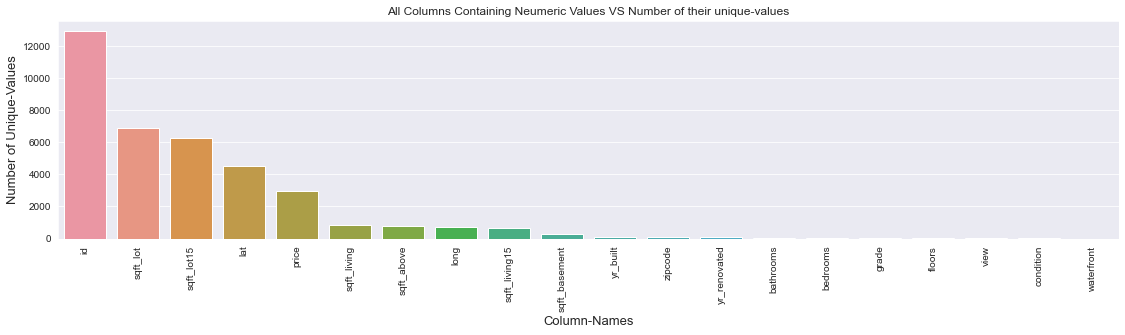

In [133]:
#adding more data rather than optimising by XGBRegressor

# SEPARATING NUMERIC COLUMNS
numeric_columns = train.select_dtypes(exclude=['object']).columns.values.tolist()
#print(numeric_columns)
print('Number of Neumeric Columns = ',len(numeric_columns))
unique_values=[]
for item in numeric_columns: 
    unique_values.append(train[item].nunique())
numeric_column_list = list(zip(numeric_columns, unique_values))
#(numeric_column_list)
numeric_column_list = sorted(numeric_column_list,key=lambda l:l[1], reverse=True)
numeric_column_list=pd.DataFrame(numeric_column_list, columns=['Column-Names', 'Unique-Values'])
                                                  
                                                  # PLOTTING NUMBER OF UNIQUE-VALUES FOR EACH NUMERIC COLUMNS
plt.subplots(figsize=(19, 4))
sns.barplot(x=numeric_column_list['Column-Names'], y=numeric_column_list['Unique-Values'])
plt.xticks(rotation=90)
plt.ylabel('Number of Unique-Values', fontsize=13)
plt.xlabel('Column-Names', fontsize=13)
plt.title('All Columns Containing Neumeric Values VS Number of their unique-values')
plt.show()

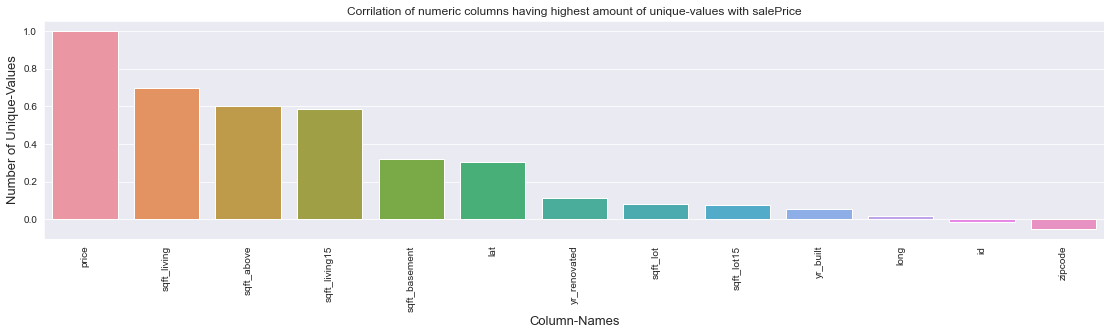

In [136]:
# CHECKING CORRELATION OF THE SELECTED COLUMNS WITH SALEPRICE
highly_unique_columns = numeric_column_list.drop(numeric_column_list[numeric_column_list['Unique-Values'] < 65].index)
#droping columns with unique values less than 65

cols = highly_unique_columns['Column-Names']
#cols = train.columns.values.tolist()
corrs=[]
for item in cols:
    corrs.append((train[item].corr(train['price'])))    # .corr is for finding correlation coefficient
    
    '''
    Pandas dataframe.corr() is used to find the pairwise correlation of all columns in the dataframe. 
    Any na values are automatically excluded. For any non-numeric data type columns in the dataframe it is ignored.
    '''
    
# MAKING A DATAFRAME TO STORE THE CORRELATIONS     
ist = pd.DataFrame(
    {'cols': cols,
     'corrs': corrs
    })
ist = ist.sort_values(by='corrs', ascending=False)

# VISUALIZING CORRELATIONS GRAPHICALLY
plt.subplots(figsize=(19, 4))
sns.barplot(x=ist['cols'], y=ist['corrs'])
plt.xticks(rotation=90)
plt.ylabel('Number of Unique-Values', fontsize=13)
plt.xlabel('Column-Names', fontsize=13)
plt.title('Corrilation of numeric columns having highest amount of unique-values with salePrice')
plt.show()

In [129]:
model_Lasso= make_pipeline(RobustScaler(), Lasso(alpha =0.000327, random_state=18))

model_ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.00052, l1_ratio=0.70654, random_state=18))


model_GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =18)

model_XGB=xgb.XGBRegressor(n_jobs=-1, n_estimators=849, learning_rate=0.015876, 
                           max_depth=58, colsample_bytree=0.599653, colsample_bylevel=0.287441, subsample=0.154134, seed=18)

model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

forest_reg = RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
                                   max_features=60, max_leaf_nodes=None, min_impurity_decrease=0.0,
                                   min_samples_leaf=1,
                                   min_samples_split=2, min_weight_fraction_leaf=0.0,
                                   n_estimators=70, n_jobs=1, oob_score=False, random_state=42,
                                   verbose=0, warm_start=False)

In [137]:
# taking 10 most correlated columns
print(ist['cols'][:9])
mst_corr_cols = ist['cols'][:9].to_list()
tr_sm = train[mst_corr_cols]
val_sm = val[mst_corr_cols]
ts_sm = test[mst_corr_cols]

4             price
5       sqft_living
6        sqft_above
8     sqft_living15
9     sqft_basement
3               lat
12     yr_renovated
1          sqft_lot
2        sqft_lot15
Name: cols, dtype: object

In [139]:
# preparing traing and test dataset
train_y = tr_sm['price']
train_x = tr_sm.drop(['price'], axis=1)

test_y = ts_sm['price']
test_x = ts_sm.drop(['price'], axis=1)

val_y = val_sm['price']
val_x = val_sm.drop(['price'], axis=1)

In [140]:
#nomralization in log sacle of prices
train_y = np.log1p(train_y)
test_y = np.log1p(test_y)
val_y = np.log1p(val_y)

In [141]:
model_Lasso.fit(train_x, train_y)
Lasso_Predictions=np.exp(model_Lasso.predict(test_x))-1 #prediction on test set
y_pred1=np.exp(model_Lasso.predict(val_x))-1 #prediction on validation set
score1 = model_Lasso.score(val_x, val_y)
print(score1)


model_ENet.fit(train_x, train_y)
ENet_Predictions=np.exp(model_ENet.predict(test_x))-1
y_pred2=np.exp(model_ENet.predict(val_x))-1
score2 = model_ENet.score(val_x, val_y)
print(score2)


model_XGB.fit(train_x, train_y)
XGB_Predictions=np.exp(model_XGB.predict(test_x))-1
y_pred3=np.exp(model_XGB.predict(val_x))-1
score3 = model_XGB.score(val_x, val_y)
print(score3)

model_GBoost.fit(train_x, train_y)
GBoost_Predictions=np.exp(model_GBoost.predict(test_x))-1
y_pred4=np.exp(model_GBoost.predict(val_x))-1
score4 = model_XGB.score(val_x, val_y)
print(score4)

model_lgb.fit(train_x, train_y)
lgb_Predictions=np.exp(model_lgb.predict(test_x))-1
y_pred5=np.exp(model_lgb.predict(val_x))-1
score5 = model_lgb.score(val_x, val_y)
print(score5)

#forest_reg.fit(train_x, train_y)
#forest_reg_Predictions=np.exp(forest_reg.predict(test_x))-1

0.6937372627079883
0.6937202156270428
0.8371681790394485
0.8371681790394485
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


NameError: name 'score5' is not defined

In [164]:
#ensmebling 

ensemble_test = (Lasso_Predictions + XGB_Predictions + lgb_Predictions + ENet_Predictions)/4 # for test set
ensemble = (y_pred1 + y_pred2 + y_pred3 + y_pred4 + y_pred5)/5 # for validation set

ensemble

array([425746.43401698, 518725.51817832, 419926.36722194, ...,
       448109.2477766 , 448697.22257468, 454157.23173966])

In [165]:
np.log1p(ensemble)

array([12.96160157, 13.15913208, 12.94783704, ..., 13.01279457,
       13.01410583, 13.02620094])

In [166]:
#loss on validation set
np.sqrt(np.square(val_y-np.log1p(ensemble))).mean()

0.17283050961883697

In [ ]:
res_col = ['id', 'price']
res_df = pd.DataFrame(rawTest, columns=res_col)
res_df['id'], res_df['price'] = test_ID, ensemble
res_df['id']= res_df['id'].astype(str).str.zfill(10)
res_df['price']= res_df['price'].round()
res_df['id'] = res_df['id'].astype(str)+test_date.astype(str)
res_df.to_csv('resultEnsm.csv', index=False)

# More Improvement

In [169]:
from sklearn import ensemble
clf = ensemble.GradientBoostingRegressor(n_estimators=400, max_depth=5, min_samples_split=2,
                                        learning_rate=0.01, loss='ls')
'''this(resultGBoostRg) yeilds res score 17.....'''

'this(resultGBoostRg) yeilds res score 17.....'

In [170]:
clf.fit(train_x, train_y)

#score on validation
clf.score(val_x, val_y)

c:\users\ripon\anaconda3\envs\mldl\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(


0.8288788167314712

In [ ]:
#prediction on test_set
pred_y = np.exp(clf.predict(test_x))-1
pred_y

#for more imporvement

In [171]:
clf = ensemble.GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                         min_samples_split=5, 
                                   loss='ls', random_state =18)
# this(resultGBoostRg2) was not better wstimation. score 18....
#score--> 0.8342707905691829

In [172]:
clf.fit(train_x, train_y)

#score on validation
clf.score(val_x, val_y)

c:\users\ripon\anaconda3\envs\mldl\lib\site-packages\sklearn\ensemble\_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(


0.8342707905691829

In [ ]:
#prediction on test_set
pred_y = np.exp(clf.predict(test_x))-1
pred_y

In [ ]:
res_col = ['id', 'price']
res_df = pd.DataFrame(rawTest, columns=res_col)
res_df['id'], res_df['price'] = test_ID, pred_y
res_df['id']= res_df['id'].astype(str).str.zfill(10)
res_df['price']= res_df['price'].round()
res_df['id'] = res_df['id'].astype(str)+test_date.astype(str)
res_df.to_csv('resultGBoostRg2.csv', index=False)

# Improving Using data preprocessing 

In [ ]:
#breaking the date into yr, mm, day
rawTrain['date']=pd.to_datetime(rawTrain['date'])
rawTrain['month'] = rawTrain['date'].apply(lambda date:date.month)
rawTrain['year'] = rawTrain['date'].apply(lambda date:date.year)

rawTest['date']=pd.to_datetime(rawTest['date'])
rawTest['month'] = rawTest['date'].apply(lambda date:date.month)
rawTest['year'] = rawTest['date'].apply(lambda date:date.year)

rawVal['date']=pd.to_datetime(rawVal['date'])
rawVal['month'] = rawVal['date'].apply(lambda date:date.month)
rawVal['year'] = rawVal['date'].apply(lambda date:date.year)

# Updating

In [ ]:
train = train.drop(train[(train['BsmtFinSF1']>2000) & (train['SalePrice']<500000)].index)
print('After outlier-removal of BsmtFinSF1: ')
outlier_check_plot('BsmtFinSF1')

In [16]:
train[train['sqft_lot']<750000]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,440000.0,3,2.50,2290,6302,2.0,0,0,3,9,2290,0,1997,0,98058,47.4350,-122.107,2700,7500
1,994000.0,5,3.25,4260,7861,2.0,0,0,3,10,4260,0,2005,0,98074,47.6110,-121.992,4020,7528
2,427000.0,3,1.75,2000,7111,1.0,0,0,4,7,1360,640,1956,0,98177,47.7676,-122.373,1830,9000
3,415000.0,3,1.75,1270,4800,1.0,0,0,3,7,1270,0,1952,2014,98126,47.5362,-122.376,1220,4800
4,335000.0,3,1.75,2100,8298,1.0,0,0,4,7,1230,870,1952,0,98166,47.4601,-122.360,1700,10830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12963,346000.0,3,3.25,1500,1442,2.0,0,0,3,8,1150,350,2007,0,98106,47.5592,-122.362,1500,1533
12964,437500.0,4,2.50,2680,7513,2.0,0,0,3,8,2680,0,1998,0,98059,47.4956,-122.161,2640,7243
12965,440000.0,6,3.00,2510,5310,1.0,0,0,4,7,1460,1050,1944,0,98108,47.5533,-122.304,1390,5407
12966,263000.0,3,1.75,1660,7210,1.0,0,0,4,7,1660,0,1977,0,98032,47.3609,-122.274,2150,7350


In [17]:
train[train['sqft_lot']>750000]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2179,542500.0,5,3.25,3010,1074218,1.5,0,0,5,8,2010,1000,1931,0,98027,47.4564,-122.004,2450,68825
2194,998000.0,4,3.25,3770,982998,2.0,0,0,3,10,3770,0,1992,0,98058,47.4140,-122.087,2290,37141
5146,1600000.0,4,5.50,6530,871200,2.0,0,2,3,11,6530,0,2008,0,98014,47.6640,-121.878,1280,858132
6138,700000.0,4,1.00,1300,1651359,1.0,0,3,4,6,1300,0,1920,0,98022,47.2313,-122.023,2560,425581
9483,190000.0,2,1.00,710,1164794,1.0,0,0,2,5,710,0,1915,0,98014,47.6888,-121.909,1680,16730
11815,937500.0,4,4.00,5545,871200,2.0,0,0,3,11,3605,1940,2003,0,98014,47.6760,-121.882,3420,871200


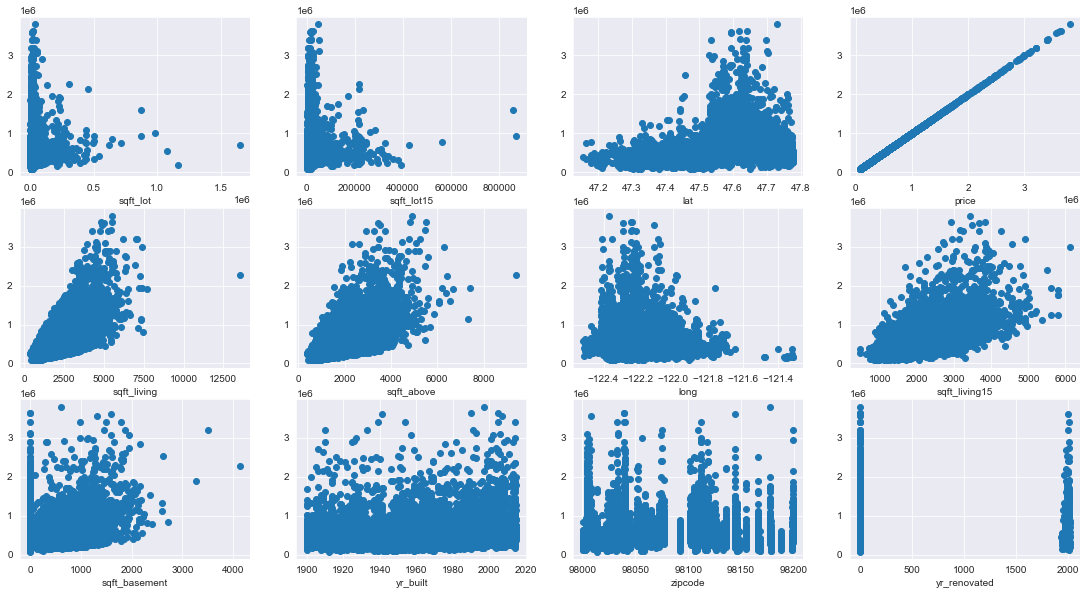

In [20]:
#price less than 4e6 looks providing better result
def relation_wid_price(c, column):
    plt.subplot(5, 4, c)
    plt.scatter(x=train[train['price']<4000000][column], y=train[train['price']<4000000]['price'])
    plt.xlabel(column)
c=1
plt.subplots(figsize=(19, 17))
for item in cols:
    relation_wid_price(c, item)
    c = c+1
plt.show()

In [79]:
train = train[train['price']<4000000]
len(train)
        

KeyError: 'price'